<a href="https://colab.research.google.com/github/joshuawhit/DST_ASS2/blob/main/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing for AI-generated text detection.

B. Minogue, H. Pullin, Y. Wang, J. White.

# Introduction

In this project, we explore different natural language classification models as applied on the LLM - Detect AI Generated Text dataset, found on the Kaggle website here: https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset. We seek to classify wether an inputted text is AI generated or Humanly generated for the role of malpratice detection in essay submissions.

We hope to explore both the performance and scalability of models ranging in complexity from a simple bag of words model up to fine tuned but pretrainined transformers. Although unavailable for this project we will discuss how and when techniques such as GPU parallelisation can be used to improve model training time.

 MAYBE MORE HERE ON LIKE THAT FANCY COMPUTER THING

# The Dataset

The dataset consists of 28000 essay pieces of essay text (with an average length of approxamtely 380 words, see below), each with an associated key representing wether it is humanly or AI generated. We choose this dataset in particular due to its source being essay data, the same type of data we hope to be able to classify. Furthermore it can be seen as quite 'clean data' (no missing values) and the data also has class proportions close to an even split, which is useful for neural model training.

# Techniques

# Performance Metrics

Due to the nature of the task at hand being a binary classifcation task we use sensitivity, F1 score and accuracy as our evaluation metrics for the models. This is as we deem the cost of misclassifiction to be higher for the positive case 'AI generated'. In other words, not detecting the text as malpractice is more detrimental than flagging human text as AI as we assume these would be checked after the preliminary screening by a human.

In [1]:
!pip install datasets
!pip install wget
!pip install fasttext
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plotter
import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from datasets import load_dataset, Dataset, load_metric
from typing import List, Callable, Dict
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.word2vec import Word2Vec
from tqdm.auto import tqdm
import wget
import zipfile
import io
import time
import torch
import gc
import traceback
import fasttext.util
from ipywidgets import widgets
from transformers import (AutoConfig, AutoTokenizer, AutoModel,
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer,
                          DataCollatorWithPadding,
                          EarlyStoppingCallback)
from transformers import logging as tf_logging
tf_logging.set_verbosity_error()
tqdm.pandas()
plt.style.use('ggplot')

Here we load our google drive to our notebook to download the dataset into a pandas dataframe.

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Training_Essay_Data.csv')
df.name = 'whole'

We create a train-test split using the sklearn built-in function, fixing the initial state for reproducibility.

In [5]:
train , test =train_test_split(df,test_size=0.2,train_size=0.8,random_state=1)
train.name = 'training'
test.name = 'testing'

In [6]:
train.head()

traindist = np.mean(train['generated'])
print('The trained data has {}% AI generated text (3s.f.)'.format(round(traindist,3)))
testdist = np.mean(test['generated'])
print('The test data has {}% AI generated text (3s.f.)'.format(round(testdist,3)))
textwords=np.zeros(len(df['text']))
for i in range(0,len(df['text'])-1):
  textwords[i] = len(df['text'][i].split())


mean_length=np.mean(np.mean(textwords))
print('The mean length of a document is {} words.'.format(round(mean_length,3)))


The trained data has 0.403% AI generated text (3s.f.)
The test data has 0.386% AI generated text (3s.f.)
The mean length of a document is 383.129 words.


From above we see the Train and Test data both have a similar split over the labels distribution. We also quikcly inspect the average length of each piece of text, noting that 383 words is quite large.

In [26]:
def draw_hist_words(histt: pd.DataFrame):
  '''Draws a histogram of the number of words in each document.

    Args:
        df:
            dataframe of texts with 'text' as the key for the documents.

    Returns:
        NA:
            plots histogram
    '''
  plt.figure(figsize=(8,5))
  histt['text'].str.split().map(lambda x: len(x)).hist()
  plt.title("Histogram of the number of words in each text for "+histt.name+" data")
  plt.xlabel('Number of characters')
  plt.ylabel('Number of documents')
  plt.show()

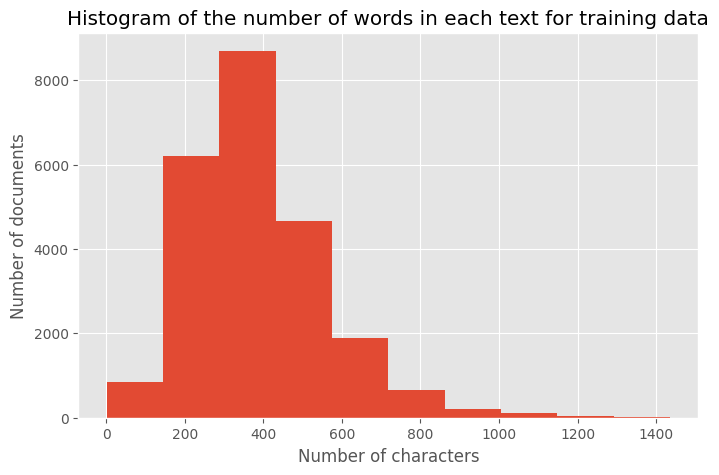

In [27]:
draw_hist_words(train)

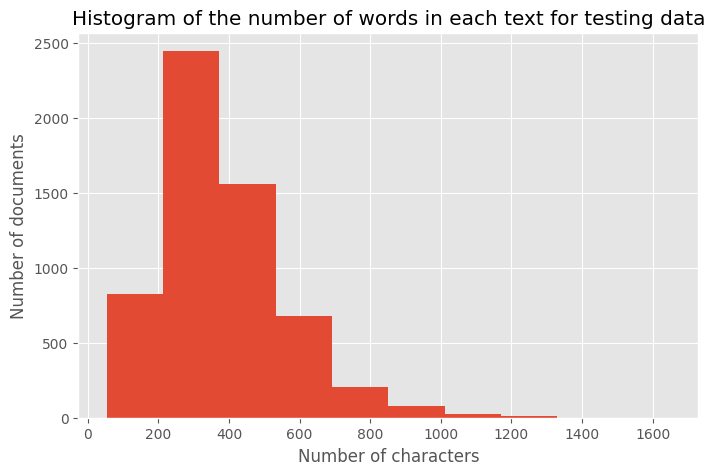

In [28]:
draw_hist_words(test)

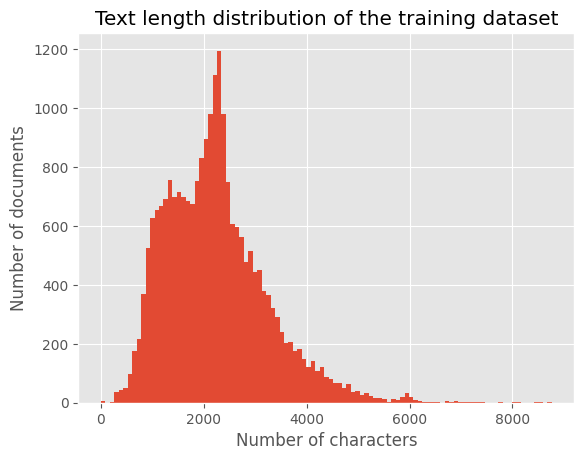

In [29]:
def plot_text_length_distribution(df: pd.DataFrame):
    '''Plots a histogram of the lengths of the texts in the dataset.

    Args:
        df (Pandas DataFrame):
            The input dataframe. Must have a 'text' column.
    '''

    df['Letter_Count'] = df['text'].apply(lambda x: len(x))
    df.Letter_Count.hist(bins='auto')
    plt.title('Text length distribution of the '+df.name+' dataset')
    plt.xlabel('Number of characters')
    plt.ylabel('Number of documents')
    plt.show()


plot_text_length_distribution(train)

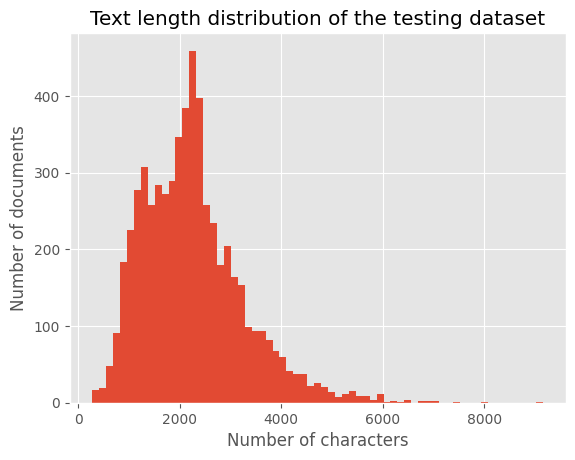

In [30]:
plot_text_length_distribution(test)

Let us now create a vocabulary.

In [7]:
def build_vocabulary(corpus: List[str]) -> List[str]:
    '''Constructs the vocabulary from a corpus.

    Args:
        list of str:
            The corpus, being a list of documents.

    Returns:
        list of str:
            A list containing all unique words in the corpus.
    '''
    # We simplify things here and remove all non-characters from the documents.
    corpus = [re.sub('^[ a-zA-Z]', '', doc) for doc in corpus]

    #We next split every document into words by spaces, and collect these
    all_words = [word for doc in corpus for word in doc.split()]
    # We then get all the unique words by converting the list to a `set` and back
    unique_words = list(set(all_words))

    # Return the vocabulary
    return unique_words


vocabulary = build_vocabulary(train.text.tolist())
len(vocabulary)

141967

Let us start with a bag of words embedding, starting from a simple one hot encoder, we add the ability to handle words outside the vocabulary (we might come across words in the test dataset which do not occur in the training dataset)

In [9]:
def one_hot_encode(word: str, vocabulary: List[str]) -> np.ndarray:
    '''One-hot encode a word according to our vocabulary.

    Args:
        word (str):
            The word to be encoded. It needs to be present
            within our vocabulary!
        vocabulary (list):
            List of unique words in the corpus.

    Returns:
        NumPy array:
            The resulting one-hot encoding.
    '''
    embedding = np.zeros(len(vocabulary))

    # Get the position at which the word appears in the vocabulary
    vocab_position = vocabulary.index(word)

    # make it a one hot vector
    embedding[vocab_position] = 1
    return embedding


one_hot_embedding = one_hot_encode('happy',vocabulary)
assert one_hot_embedding.sum() == 1
one_hot_embedding

array([0., 0., 0., ..., 0., 0., 0.])

In [10]:
def improved_one_hot_encode(word: str, vocabulary: List[str]) -> np.ndarray:
    '''One-hot encode a word.

    This can also deal with words not in the vocabulary.

    Args:
        word (str):
            The word to be encoded.
        vocabulary (list):
            List of unique words in the corpus.

    Returns:
        NumPy array:
            The resulting one-hot encoding.
    '''

    # Return the embedding, whether it came from the "try block"
    # or the "except block"
    try:
        # We embed using our previous function, and add a zero at the end, showing it IS in the vocabulary
        embedding = np.concatenate((one_hot_encode(word, vocabulary), [0]))

    except ValueError:
        #when the word is not in our vocabulary.
        embedding = np.zeros(len(vocabulary) + 1)
        embedding[-1] = 1
    return embedding
    return embedding

embedding = improved_one_hot_encode('Thisisnotaword',vocabulary)
assert embedding.sum() == 1
embedding

array([0., 0., 0., ..., 0., 0., 1.])

In [11]:
def bag_of_words_embed(doc: str) -> np.ndarray:
    '''Embed a document using the bag-of-words representation.

    Args:
        doc (str):
            The document we want to embed.

    Returns:
        NumPy array:
            The resulting bag-of-words embedding.
    '''
    # We simplify things here and remove all non-characters from the document,
    # just like we did when we created the vocabulary
    doc = re.sub('[^a-zA-Z ]', '', doc)

    # Split up the document into a list of words
    words = doc.split()

    # Embed all the words, resulting in a list of NumPy arrays
    embeddings = [improved_one_hot_encode(word,vocabulary) for word in words]

    # Sum up all the one-hot encoded vectors in `embeddings`
    bag_of_words_embedding = np.sum(embeddings, axis=0)

    # Return the embedding
    return bag_of_words_embedding


embedding = bag_of_words_embed('This is a test')
assert embedding.sum() == 4
embedding

array([0., 0., 0., ..., 0., 0., 0.])

We have now created a simple bag of words embedding from scratch. Lets see how slow this is.

In [ ]:
#bag_of_words_embeddings_train = np.stack(train.text.progress_apply(bag_of_words_embed))


This would take us over 30 hours to complete. This is not feesable and so we create a much smaller version of the datset, so we can hope to find some results.

In [8]:

small_train , small_test =train.iloc[:500],test.iloc[:100]
small_train.name = 'training'
small_test.name = 'testing'

We create a new Vocabulary, noting the size has greatly reduced.

In [13]:
vocabulary = build_vocabulary(small_train.text.tolist())
len(vocabulary)

16743

Let use our functions on this smaller dataset.

In [37]:
bag_of_words_embeddings_train = np.stack(small_train.text.progress_apply(bag_of_words_embed))
bag_of_words_embeddings_train.shape

  0%|          | 0/500 [00:00<?, ?it/s]

(500, 16744)

In [38]:
bag_of_words_embeddings_test = np.stack(small_test.text.progress_apply(bag_of_words_embed))

  0%|          | 0/100 [00:00<?, ?it/s]

That still takes a long time... We save the results in a csv for as so we do not have to run this again.

This is to be expected with the massive length of the word representations, because the ebeddings are the size of the vocabulary itself.

In [ ]:
#np.savetxt('bag_of_words_train.csv', bag_of_words_embeddings_train, delimiter=',')
#np.savetxt('bag_of_words_test.csv', bag_of_words_embeddings_test, delimiter=',')

below is code to load the data back in.

In [ ]:
#bag_of_words_embeddings_train = pd.read_csv('bag_of_words_train.csv', sep=',', header=None)
#bag_of_words_embeddings_test = pd.read_csv('bag_of_words_test.csv', sep=',', header=None)
#bag_of_words_embeddings_train = bag_of_words_embeddings_train.to_numpy()
#bag_of_words_embeddings_test = bag_of_words_embeddings_test.to_numpy()

KeyboardInterrupt: ignored

In [39]:
# Define the model
model = LogisticRegression(max_iter=1_000)

# Train the model
model.fit(bag_of_words_embeddings_train, small_train.generated)

LogisticRegression(max_iter=1000)

In [40]:
# Note that the metric used by the `score` method varies from model to
# model. For the logistic regression model this metric is accuracy.
test_acc = model.score(bag_of_words_embeddings_test, small_test.generated)
print(f'The model achieved a {100 * test_acc:.2f}% accuracy '
      f'on the test set.')

The model achieved a 96.00% accuracy on the test set.


In [41]:
predictions = model.predict(bag_of_words_embeddings_test)
test_balanced_acc = balanced_accuracy_score(small_test.generated, predictions)
print(f'The model achieved a {100 * test_balanced_acc:.2f}% balanced '
      f'accuracy on the test set.')

The model achieved a 96.26% balanced accuracy on the test set.


In [42]:
def test_vocabulary(corpus1: List[str], corpus2: List[str]) -> List[str]:
    '''Find the percentage of words seen inside corpus2 that are also inside corpus2.

    Args:
        list of str:
            The corpus1, being a list of documents.
            The corpus2, being a list of documents.

    Returns:
        float:
            percentage of words seen in corpus2 that are also in corpus1.
    '''
    # We simplify things here and remove all non-characters from the documents.
    corpus1 = [re.sub('^[ a-zA-Z]', '', doc) for doc in corpus1]
    corpus2 = [re.sub('^[ a-zA-Z]', '', doc) for doc in corpus2]
    #We next split every document into words by spaces, and collect these
    all_words1 = [word for doc in corpus1 for word in doc.split()]
    all_words2 = [word for doc in corpus2 for word in doc.split()]
    # We then get all the unique words by converting the list to a `set` and back
    unique_words1 = list(set(all_words1))
    unique_words2 = list(set(all_words2))

    same_words = list(set(unique_words1).intersection(unique_words2))

    percentage = (len(same_words)/len(unique_words2))*100


    # Return the percentage
    return percentage



In [43]:
similarity = test_vocabulary(small_train['text'],small_test['text'])

In [44]:
print(f'{similarity:.2f}% of the words in the corpus for the small test set were seen in the small train set.')


73.11% of the words in the corpus for the small test set were seen in the small train set.


These results seem dubious in nature as current leading models in this domain are not nearly as accurate (***SEEE REFFFFFFF!!!!!!!***). I hypothesise that the model is only looking at the last digit as all words are seem n the training data, but ony approximately 75% are seen otherwise.

In [56]:
model.coef_[0][-1]


-0.019063711354282906

In [60]:
print(str(model.coef_[0][1])+' '+ str(model.coef_[0][4])+' ' +str(model.coef_[0][5])+' '+ str(model.coef_[0][10]))

0.0 0.0 0.0  0.0


The last coefficient is non-zero and many of the other seem to be zero. Lets modify the functions to handel new data differrently.

In [25]:
def improved_one_hot_encode2(word: str, vocabulary: List[str]) -> np.ndarray:
    '''One-hot encode a word.

    This can also deal with words not in the vocabulary, by setting it to a random word.

    Args:
        word (str):
            The word to be encoded.
        vocabulary (list):
            List of unique words in the corpus.

    Returns:
        NumPy array:
            The resulting one-hot encoding.
    '''

    # Return the embedding, whether it came from the "try block"
    # or the "except block"
    try:
        # We embed using our previous function, and add a zero at the end, showing it IS in the vocabulary
        embedding = one_hot_encode(word,vocabulary)

    except ValueError:
        #when the word is not in our vocabulary.
        index = random.randint(0,len(vocabulary)-1)
        embedding = np.zeros(len(vocabulary))
        embedding[index] = 1
    return embedding
    return embedding

embedding = improved_one_hot_encode2('segesgrggrhdhttfhffth',vocabulary)
assert embedding.sum() == 1
embedding

array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
def bag_of_words_embed2(doc: str) -> np.ndarray:
    '''Embed a document using the bag-of-words representation.

    Args:
        doc (str):
            The document we want to embed.

    Returns:
        NumPy array:
            The resulting bag-of-words embedding.
    '''
    # We simplify things here and remove all non-characters from the document,
    # just like we did when we created the vocabulary
    doc = re.sub('[^a-zA-Z ]', '', doc)

    # Split up the document into a list of words
    words = doc.split()

    # Embed all the words, resulting in a list of NumPy arrays
    embeddings = [improved_one_hot_encode2(word,vocabulary) for word in words]

    # Sum up all the one-hot encoded vectors in `embeddings`
    bag_of_words_embedding = np.sum(embeddings, axis=0)

    # Return the embedding
    return bag_of_words_embedding


embedding = bag_of_words_embed2('This is a test')
assert embedding.sum() == 4
embedding

array([0., 0., 0., ..., 0., 0., 0.])

In [66]:
bag_of_words_embeddings_test2 = np.stack(small_test.text.progress_apply(bag_of_words_embed2))
bag_of_words_embeddings_train2 = np.stack(small_train.text.progress_apply(bag_of_words_embed2))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [67]:

# Define the model
model = LogisticRegression(max_iter=1_000)

# Train the model
model.fit(bag_of_words_embeddings_train2, small_train.generated)

# Note that the metric used by the `score` method varies from model to
# model. For the logistic regression model this metric is accuracy.
test_acc2 = model.score(bag_of_words_embeddings_test2, small_test.generated)
print(f'The model achieved a {100 * test_acc2:.2f}% accuracy '
      f'on the test set.')

predictions2 = model.predict(bag_of_words_embeddings_test2)
test_balanced_acc2 = balanced_accuracy_score(small_test.generated, predictions2)
print(f'The model achieved a {100 * test_balanced_acc2:.2f}% balanced '
      f'accuracy on the test set.')

The model achieved a 94.00% accuracy on the test set.
The model achieved a 94.74% balanced accuracy on the test set.


In [31]:
medium_train = train.iloc[:1000]
medium_test = test.iloc[:500]
bag_of_words_embeddings_test3 = np.stack(medium_test.text.progress_apply(bag_of_words_embed2))
bag_of_words_embeddings_train3 = np.stack(medium_train.text.progress_apply(bag_of_words_embed2))

# Define the model
model = LogisticRegression(max_iter=1_000)

# Train the model
model.fit(bag_of_words_embeddings_train3, medium_train.generated)

# Note that the metric used by the `score` method varies from model to
# model. For the logistic regression model this metric is accuracy.
test_acc3 = model.score(bag_of_words_embeddings_test3, medium_test.generated)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [30]:
print(f'The model achieved a {100 * test_acc3:.2f}% accuracy '
      f'on the test set.')

predictions3 = model.predict(bag_of_words_embeddings_test3)
test_balanced_acc3 = balanced_accuracy_score(medium_test.generated, predictions3)
print(f'The model achieved a {100 * test_balanced_acc3:.2f}% balanced '
      f'accuracy on the test set.')

The model achieved a 97.50% accuracy on the test set.
The model achieved a 97.73% balanced accuracy on the test set.


In [68]:
# Delete the bag-of-words embeddings again, to save some memory
del bag_of_words_embeddings_train, bag_of_words_embeddings_test, model
gc.collect()

6924

# TF-IDF Representation
We will now try to embed the documents using the TF-IDF representation and see if we can improve upon our previous classification score.

Rather than coding this from scratch, we will employ the `TfidfVectorizer` from the `sklearn` library.

The following function will be using that vectorizer to compute our vocabulary and all the document frequencies.

In [69]:
def fit_tfidf(corpus: List[str], **tfidf_params) -> TfidfVectorizer:
    '''Fit a TF-IDF model on a corpus.

    This computes the vocabulary and stores all the
    document frequencies in the class.

    Args:
        corpus (list of str):
            The corpus on which the TF-IDF model will
            be fitted.
        **tfidf_params:
            Extra keyword parameters to include in the TF-IDF model.

    Returns:
        TfidfVectorizer:
            The fitted TF-IDF model.
    '''

   # Initialise the class computing the TF-IDF embeddings
    tfidf = TfidfVectorizer(**tfidf_params)

    # Use the `fit` method of `tfidf` on the corpus, which
    # computes the vocabulary and all the document
    # frequencies from the training dataset, and stores
    # them.
    tfidf = tfidf.fit(corpus)

    # Return the fitted TF-IDF model
    return tfidf



tfidf = fit_tfidf(train.text)
tfidf

TfidfVectorizer()

That was much quicker! Next, just like with bag-of-word, we embed our corpus and train a logistic regression model on the embeddings. We will be using our new fitted `TfidfVectorizer` to compute the embeddings this time.

In [70]:
def tfidf_train_model(tfidf_model: TfidfVectorizer,
                      train_dataset: pd.DataFrame,
                      test_dataset: pd.DataFrame) -> LogisticRegression:
    '''Trains a logistic regression model on a TF-IDF embedded corpus.

    Args:
        tfidf_model (TfidfVectorizer):
            The fitted TF-IDF model.
        train_dataset (Pandas DataFrame):
            The dataset on which to train the logistic regression
            model. Must have a 'text' and 'generated' column.
        test_dataset (Pandas DataFrame):
            The dataset on which to evaluate the logistic regression
            model. Must have a 'text' and 'generated' column.

    Returns:
        LogisticRegression:
            The trained model.
    '''
       # Embed the training dataset using the TF-IDF representation
    tfidf_embeddings_train = tfidf_model.transform(train_dataset['text'])

    # Embed the validation dataset using the TF-IDF representation
    tfidf_embeddings_test = tfidf_model.transform(test_dataset['text'])

    # Define the model
    model = LogisticRegression(max_iter=1000)

    # Train the model
    model.fit(tfidf_embeddings_train, train_dataset['generated'])

    # Evaluate the model on the validation set.
    predictions = model.predict(tfidf_embeddings_test)
    test_balanced_acc = balanced_accuracy_score(test_dataset['generated'], predictions)
    print(f'The model achieved a {100 * test_balanced_acc:.2f}% '
          f'balanced accuracy on the test set.')

    # Return the trained model
    return model

model = tfidf_train_model(tfidf_model=tfidf, train_dataset=train, test_dataset=test)

The model achieved a 98.70% balanced accuracy on the test set.


Even better results, in a fraction of the time. For bag of words, we had to look at a small problem to even run the embedding in a reasonable time. Embedding the whole train set was going to take over 24 hours, which is over the maximum google colab allows for wuthout a subscription service.

By default the `TfidfVectorizer` normalises the embeddings. In this scenario this is counterproductive, let us explore the effect of removing this normalisation.

In [71]:
improved_tfidf = fit_tfidf(train.text, norm=None)
improved_model = tfidf_train_model(tfidf_model=improved_tfidf,
                                   train_dataset=train,
                                   test_dataset=test)

The model achieved a 99.59% balanced accuracy on the test set.


These results seem too good to be true. Let us ask chatGPT to write us a sample 275 word essay to predict, and some text generated by me.

In [12]:
sample_essay = {'text':["In the face of escalating environmental challenges, the need for environmental education has become increasingly imperative in the 21st century. This essay explores the significance of environmental education in fostering a sustainable future. Environmental education plays a pivotal role in raising awareness about pressing ecological issues. As global concerns such as climate change, deforestation, and biodiversity loss continue to escalate, it is essential for individuals to comprehend the intricate relationships between human activities and the environment. Environmental education provides the knowledge and tools necessary for people to understand the consequences of their actions and empowers them to make informed, sustainable choices.Beyond awareness, environmental education cultivates a sense of responsibility and stewardship toward the planet. By instilling a deep appreciation for nature and its interconnected systems, individuals are more likely to adopt eco-friendly practices in their daily lives. This can range from simple actions like reducing waste and conserving energy to advocating for policy changes that promote environmental sustainability. Furthermore, environmental education equips individuals with the skills needed to address complex environmental challenges. As the world grapples with issues like resource depletion and pollution, there is a growing demand for innovative solutions. Environmental education fosters critical thinking, problem-solving, and a multidisciplinary approach to address these challenges, preparing individuals to contribute meaningfully to the development and implementation of sustainable practices. In conclusion, environmental education is a linchpin in creating a sustainable and harmonious future. By imparting knowledge, fostering a sense of responsibility, and nurturing the skills required to tackle environmental issues, it empowers individuals to become active participants in the ongoing effort to preserve and protect our planet for generations to come."
,"In the contemporary digital landscape, social media has become an integral part of daily life, transforming the way individuals connect and communicate. This essay delves into the multifaceted impact of social media on mental health, exploring both its positive and negative implications. While social media provides a platform for self-expression, community building, and information sharing, it also raises concerns about issues like cyberbullying, social comparison, and the potential for addiction. Striking a balance between the benefits and drawbacks of social media is essential for promoting a healthy online environment and safeguarding mental well-being."
,"The integration of artificial intelligence (AI) into healthcare has ushered in a new era of medical innovation and efficiency. This essay examines the advantages and challenges associated with the use of AI in healthcare. On the positive side, AI facilitates faster and more accurate diagnostics, personalized treatment plans, and the optimization of administrative processes. However, concerns regarding data privacy, ethical considerations, and the potential for job displacement underscore the need for careful regulation and ethical guidelines in the ongoing development and implementation of AI in the healthcare sector."
,"Climate change is a pressing global issue with far-reaching consequences, particularly for vulnerable communities around the world. This essay explores the disproportionate impact of climate change on low-income countries and marginalized populations. Rising sea levels, extreme weather events, and food insecurity are among the challenges exacerbating existing social inequalities. Addressing the global climate crisis requires collaborative efforts, international cooperation, and a commitment to sustainable practices to ensure the well-being and resilience of communities most affected by the changing climate."
,"From our literature review, it was found that there have several projects that set out to solve and research similar issues as ours however often not in the same context of golf. Our literature review covers the different methods we have used for image segmentation, both supervised and unsupervised, while also looking at the use of an AI path-finding system."
,"K-means clustering is a supervised machine learning algorithm used for grouping similar data points together with one predetermined hyper-parameter K. In the context of processing images of golf courses, K-means clustering can be used to group similar pixels together based on the pixel's RGB value, segmenting the image into distinct regions. Each pixel in an image is treated as an individual data point containing 3 values in a high-dimensional feature space of all the pixels. In this feature space, the distance between two pixels is defined as the euclidean distance between their associated RGB values. The K-means algorithm then randomly initialises K cluster centroids in the feature space and assigns each pixel to the nearest centroid based on minimising this euclidean distance. It then updates the centroid position, setting it to the mean of the positions of all the pixels assigned to that centroid. The algorithm repeats this process iteratively until the centroids no longer change or a maximum number of iterations is reached. It should be noted that the only information used for this clustering is the colours of the pixels, there is no use of context around each pixel or even the position of the pixel in the image. This model is designed to be a benchmark for future models which intend to use this additional context to improve the accuracy and repeatability of the segmentation."
,"In this section we explore different frameworks and methodologies to construct models on time series data for the purpose of accurate forecasting. We have already seen the generality of the VAR model as shown by lemma as a result of Wold's decomposition theorem. This makes the VAR model an attractive, accurate choice when trying to map the temporal relationships between variables. However to create a VAR model which has been fully parameterised we are required to estimate all the AR coefficients. For a VAR(p) model of dimension K this is estimates. This becomes computationally difficult for many real world applications due to the large number of parameters often used even a medium-sized dataset can cause issues. It is widely believed that in a VAR(p) model it would be unreasonable to expect all features to have a causal relationship with all other features at all lags."
,"When we do not receive hole cards containing a pair, there are 94 ways of receiving three of a kind on the flop. To calculate this we fix two of the cards in the flop to be the cards we need to make a three of a kind. For example if our hand is we fix two of the cards to be jacks. This leaves us with 47 cards which can be the other card in the flop (as we must exclude the other card left which would make four of a kind, which in our example would be the fourth jack). As we have two cards in our hand we must multiply this result by 2 to account for both, giving us 94 ways of receiving a three of a kind on the flop. "]
,'generated':[1,1,1,1,0,0,0,0]}

In [100]:
improved_tfidf = fit_tfidf(train.text, norm=None)
improved_model = tfidf_train_model(tfidf_model=improved_tfidf,
                                   train_dataset=train,
                                   test_dataset=sample_essay)

The model achieved a 50.00% balanced accuracy on the test set.


50% balanced accuracy... the classifier predicts only one class! Clearly ....

# Word2Vec Representation

Word2Vec is an algorithm developed in 2013 (Mikolov, T., Chen, K., Corrado, G. and Dean, J., 2013. Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781.). It makes use of a neural network to learn word associtions from a corpus of text.

The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text.

We use the built in `Gensim` library.

In [42]:
def fit_word2vec(corpus: List[str]) -> Word2Vec:
    '''Fit Word2Vec vectors on a corpus.

    Args:
        corpus (list of str):
            The corpus to fit the embeddings on.

    Returns:
        Word2Vec:
            The object containing the fitted embeddings.
    '''
    # Tokenise the corpus
    corpus = [re.split(r' |(?=[\.\,\-\"\'\!])', doc) for doc in corpus]

    # Fit the embeddings
    word2vec = Word2Vec(sentences=corpus, sg=1, workers=-1)

    # Return the object containing the fitted embeddings
    return word2vec


word2vec = fit_word2vec(small_train.text)
word2vec

In [43]:
word2vec.wv['test']


array([-8.8638961e-03,  4.3264558e-03,  9.5497621e-03, -6.3164579e-03,
       -5.8996486e-03,  7.1966409e-04,  5.1680016e-03,  4.3122494e-03,
       -1.9523478e-03,  4.0620551e-03, -9.7053517e-03,  6.4949119e-03,
       -3.5250736e-03, -2.0121264e-03,  5.5939294e-03, -7.9307137e-03,
       -7.6381303e-03,  7.6989508e-03,  6.4368295e-03,  9.6956494e-05,
        8.2491152e-03, -7.3581408e-03, -1.9289851e-04, -6.1440347e-03,
        3.2217740e-03, -3.8276790e-04, -8.6066173e-03,  3.7629497e-03,
       -5.4180194e-03,  7.1463976e-03, -7.9163862e-03,  2.4884772e-03,
       -5.1353634e-03, -9.8945526e-03,  3.5693061e-03,  5.6585250e-03,
        8.6320722e-03,  7.1790074e-03,  9.2333183e-03,  6.1787199e-03,
       -7.0518707e-03, -6.5340758e-03,  5.1403162e-04,  6.4951179e-05,
       -5.5826949e-03,  9.6888337e-03, -3.0025507e-03,  5.3464305e-03,
       -9.2615662e-03, -4.3795719e-03,  1.8444824e-03, -2.1074819e-03,
        1.6231990e-03, -1.1974275e-03,  4.2855907e-03, -6.9767986e-03,
      

Currently we have no way to deal with unseen vocabulary.

In [44]:
try:
    word2vec.wv['Test']
except:
    traceback.print_exc()

Traceback (most recent call last):
  File "<ipython-input-44-6eee34873b83>", line 2, in <cell line: 1>
    word2vec.wv['Test']
  File "/usr/local/lib/python3.10/dist-packages/gensim/models/keyedvectors.py", line 403, in __getitem__
    return self.get_vector(key_or_keys)
  File "/usr/local/lib/python3.10/dist-packages/gensim/models/keyedvectors.py", line 446, in get_vector
    index = self.get_index(key)
  File "/usr/local/lib/python3.10/dist-packages/gensim/models/keyedvectors.py", line 420, in get_index
    raise KeyError(f"Key '{key}' not present")
KeyError: "Key 'Test' not present"


To fix this let us do the same as in the bag of words approach: a new vector for all terms not seen before.

In [45]:
def word2vec_embed_term(term: str) -> np.ndarray:
    '''Embeds a term using the fitted Word2vec model.

    Args:
        term (str):
            The term to be embedded.

    Returns:
        NumPy array:
            The embedding of the term.
    '''
    # We do a `try-except` here to deal with out-of-vocabulary terms,
    # just like we did with the bag-of-words model
    try:
        embedding = word2vec.wv[term]

    # If the word is not in our vocabulary, then we just
    # embed it as the zero vector
    except KeyError:
        embedding = np.zeros(word2vec.vector_size)

    # Return the embedding
    return embedding


word2vec_embed_term('dfgdrgdgd')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

We next go from embedding terms to embedding documents. We also need an additional aggregation function, we use the mean as the default.

In [46]:
def word2vec_embed_doc(doc: str,
                       aggregation_fn: Callable = np.mean) -> np.ndarray:
    '''Embeds a document using the fitted Word2vec model.

    Args:
        doc (str):
            The document to be embedded.
        aggregation_fn (callable, optional):
            The function used to aggregate the term embeddings
            in the document. Must be a NumPy function. Defaults to
            `numpy.mean`, meaning that the average of the term
            embeddings is returned.

    Returns:
        NumPy array:
            The embedding of the document.
    '''
    # Split up the document into a list of terms
    terms = re.split(r' |(?=[\.\,\-\"\'\!])', doc)

    # TODO: Embed each term using the fitted `word2vec` model.
    #       The result should be a list of embeddings, one for
    #       each term.
    # Embed each term using the fitted `word2vec` model.
    embeddings = np.array([word2vec_embed_term(term) for term in terms])

    # Aggregate the embeddings according to `aggregation_fn`
    embedding = aggregation_fn(embeddings, axis=0)


    # Return the aggregated embedding
    return embedding


word2vec_embed_doc('this is a test')

array([ 2.38750270e-03,  2.90311058e-04,  3.83760757e-03,  1.52896740e-03,
       -5.20556001e-04,  6.39754522e-04,  5.46273403e-03, -1.59447745e-03,
       -1.04561425e-03,  1.82120129e-04,  1.50389504e-04, -5.51422941e-04,
       -5.39238099e-05,  2.01329496e-03, -1.33148814e-03, -3.25025874e-03,
        3.19219660e-03,  1.89845474e-03, -8.95556062e-04, -2.48114322e-03,
        6.01055450e-04,  1.39021792e-03,  2.82399589e-03, -2.37373053e-03,
       -1.55980175e-03,  7.86952325e-04, -5.79395937e-03,  1.10145868e-03,
       -4.24221531e-03,  2.63396115e-03,  6.99192751e-05,  1.76717748e-03,
       -3.29409586e-03, -4.74218605e-03, -3.10742133e-03, -6.61046477e-04,
       -1.21878530e-03,  1.67990301e-03,  9.51584778e-04, -1.35129807e-03,
        2.89591379e-04, -4.23518801e-03, -3.63227155e-04, -2.18319311e-03,
        1.39065203e-04,  4.11677547e-03, -6.31115492e-03, -1.57025666e-03,
       -5.39028668e-04, -2.20779795e-04, -2.28140107e-03, -5.53941820e-03,
        1.92669372e-03, -

In [47]:
train['text'][4]

'  The Path to Sustainable Urban Living  In an age of rapid urbanization, the concept of car-free cities is gaining momentum as a visionary solution to the complex challenges posed by urban areas. Car-free cities are urban environments where private automobiles are either heavily restricted or completely prohibited, promoting the use of sustainable transportation alternatives and fostering a healthier, more vibrant urban lifestyle. This essay explores the concept of car-free cities, examining the potential benefits, challenges, and strategies for their successful implementation.  Car-free cities offer a vision of urban living focused on sustainability and well-being:  Environmental Sustainability: By significantly reducing the number of cars on the road, car-free cities contribute to cleaner air and a reduction in greenhouse gas emissions, thus playing a vital role in mitigating climate change.  Public Health: These cities prioritize pedestrian and cyclist safety, leading to fewer acci

Okay, we can not test the classification performance of the Word2vec embeddings.

In [48]:
def word2vec_train_model(train_dataset: pd.DataFrame,
                         test_dataset: pd.DataFrame) -> LogisticRegression:
    '''Trains a logistic regression model on a Word2vec embedded corpus.

    Args:
        train_dataset (Pandas DataFrame):
            The dataset on which to train the logistic regression
            model. Must have a 'text' and 'generated' column.
        test_dataset (Pandas DataFrame):
            The dataset on which to evaluate the logistic regression
            model. Must have a 'text' and 'generated' column.

    Returns:
        LogisticRegression:
            The trained model.
    '''
    # Embed the dataset
    word2vec_embeddings_train = [word2vec_embed_doc(str(doc)) for doc in train_dataset['text']]
    word2vec_embeddings_test = [word2vec_embed_doc(str(doc)) for doc in test_dataset['text']]

    # Convert the lists of embeddings to one big matrix
    word2vec_embeddings_train = np.stack(word2vec_embeddings_train)
    word2vec_embeddings_test = np.stack(word2vec_embeddings_test)

    # Define the classification model, as there are an unequal number of classes we balance the class weight.
    model = LogisticRegression(max_iter=1_000,class_weight = 'balanced')

    # Train the model
    model.fit(word2vec_embeddings_train, train_dataset.generated)

    # Evaluate the model on the validation set.
    predictions = model.predict(word2vec_embeddings_test)
    #print(predictions)
    test_balanced_acc = balanced_accuracy_score(test_dataset.generated, predictions)
    print(f'The model achieved a {100 * test_balanced_acc:.2f}% '
          f'balanced accuracy on the test set.')

    # Return the trained model
    return model


model = word2vec_train_model(train_dataset=small_train, test_dataset=small_test)

The model achieved a 76.11% balanced accuracy on the test set.


That was... not as good. What went wrong?

Word2Vec starts training in random places, and needs to deduce that a pair of words are alike. This can only be done when it has seen a plethora of information rich examples which nudge these words into similar postions in the embedding. Thus it seems natural that to arrange the embedding space such that all pairwise similarities are upheld *simultaneously*, we require a very large set of opportunities to 'nugde' the embeddings in such a way.

In our revatively small dataset, there might be no examples where the desired-to-be-alike words are in similar nearby-word contexts. This problem is exacerbated when embeddings need to move far for their original initialisation.

The essence of Word2Vec is using bulk data, and bulk training, to force the creation and mapping of generalisable patterns. This leads us naturally into the next seciton in which we shall employ the use of pretrained `FastText` vectors where we hope to show the scalability of this representation.


In [49]:
word2vec = fit_word2vec(train.text)
word2vec

In [50]:
model_larger = word2vec_train_model(train_dataset=train, test_dataset=test)

The model achieved a 81.25% balanced accuracy on the test set.


Increasing the training data increased performance by approximately 5%. This indicates the need for a large corpus when using Word2Vec.

Let us test against our small sample outside of the dataset.

In [51]:
sample_essay = pd.DataFrame.from_dict(sample_essay)
model_sample = word2vec_train_model(train_dataset=train, test_dataset=sample_essay)

The model achieved a 87.50% balanced accuracy on the test set.


It no longer fails completely!

In [ ]:
# Delete the Word2vec embeddings again, to save some memory
del word2vec, model
gc.collect()

180

## Transformer Representation

The transformer, first introduced in (Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A.N., Kaiser, Ł. and Polosukhin, I., 2017. Attention is all you need. Advances in neural information processing systems, 30.) is a deep learning architecture which uses the concept of attention to process text.

We utilise transfer learning here. To achieve this, we use the `transformers` library, which makes using state-of-the-art transformer embeddings really simple.

In this section we will be using the `Hello-SimpleAI/chatgpt-detector-roberta` model, a pretrained model available on [the HuggingFace Hub](https://hf.co). We use this model as it has been trained on ai generated text data, and we hope this will allow our model to generalise better.

In [9]:
def load_pretrained_transformer(model_id: str = 'Hello-SimpleAI/chatgpt-detector-roberta') -> tuple:
    '''Load pretrained transformer with its tokeniser.

    Args:
        model_id (str, optional):
            The transformer model to load. Defaults to 'roberta-base'.

    Returns:
        tuple:
            A pair of the pretrained transformer and its tokeniser.
    '''
    # Create list of all the labels in the dataset
    generated = [0,1]

    # Load model
    config = dict(num_labels=len(generated),
                  id2label={id:lbl for id, lbl in enumerate(generated)},
                  label2id={lbl:id for id, lbl in enumerate(generated)})
    config = AutoConfig.from_pretrained(model_id, **config)
    tokeniser = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                               config=config)

    return model, tokeniser


tf_model, tokeniser = load_pretrained_transformer()

In [10]:
doc = 'This tokeniser is really quite extravagant.'
[tokeniser.decode(tok) for tok in tokeniser(doc).input_ids]

['<s>',
 'This',
 ' token',
 'iser',
 ' is',
 ' really',
 ' quite',
 ' extravagant',
 '.',
 '</s>']

In [13]:
def tokenise_corpus(dataset: pd.DataFrame, tokeniser) -> Dataset:
    '''Tokenises a dataset according to a pretrained tokeniser.

    Args:
        dataset (Pandas DataFrame):
            The dataset to tokenise. Must have 'text' and 'label' columns.

    Returns:
        HuggingFace Dataset:
            The tokenised dataset.
    '''
    # Build HuggingFace datasets
    dataset = Dataset.from_dict(dict(doc=dataset.text, labels=dataset.generated))

    # TODO: Create a function which takes a dictionary as input and which calls
    #       our `tokeniser` on the `doc` entry of the dictionary. When calling
    #       `tokeniser` you want to set `truncation=True` and `padding=True`, as
    #       otherwise you will encounter an error!
    def tokenise(examples: dict) -> dict:
        return tokeniser(examples['doc'], truncation=True, padding=True)

    # Tokenise dataset
    tokenised = dataset.map(tokenise, batched=True)


    # Return tokenised dataset
    return tokenised

tokenised_train = tokenise_corpus(small_train, tokeniser=tokeniser)
tokenised_test = tokenise_corpus(small_test, tokeniser=tokeniser)
sample_essay = pd.DataFrame.from_dict(sample_essay)
tokenised_sample = tokenise_corpus(sample_essay, tokeniser=tokeniser)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

In [14]:
!pip install transformers[torch]

In [15]:
! pip install -U accelerate
! pip install -U transformers

In [16]:
def finetune_transformer(tf_model,
                         tokenised_train: Dataset,
                         tokenised_test: Dataset):
    '''Train transformer model.

    Args:
        tf_model (HuggingFace Transformer):
            Pretrained transformer.
        tokenised_train (Dataset):
            Tokenised train dataset.
        tokenised_test (Dataset):
            Tokenised test dataset.

    Returns:
      HuggingFace Transformer:
          Finetuned transformer.
    '''
    # Set up training arguments
    tf_logging.set_verbosity_warning()
    training_args = TrainingArguments(
        output_dir='.',
        evaluation_strategy='epoch',
        logging_strategy='epoch',
        save_strategy='epoch',
        num_train_epochs=20,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=4,
        learning_rate=2e-5,
        warmup_steps=len(train) // 8,
        save_total_limit=1,
        load_best_model_at_end=True
    )

    def compute_metrics(predictions_and_labels: tuple) -> dict:
        '''Helper function to compute the balanced accuracy'''
        predictions, generated = predictions_and_labels
        predictions = predictions.argmax(axis=-1)
        results = balanced_accuracy_score(generated, predictions)
        #print(generated)
        #print(predictions)
        return dict(balanced_accuracy=results)

    # Initialise the Trainer object
    trainer = Trainer(model=tf_model,
                      args=training_args,
                      train_dataset=tokenised_train,
                      eval_dataset=tokenised_test,
                      tokenizer=tokeniser,
                      compute_metrics=compute_metrics)

    # Train
    trainer.train()

    return tf_model



In [17]:
tf_model = finetune_transformer(tf_model=tf_model,
                                tokenised_train=tokenised_train,
                                tokenised_test=tokenised_test)

KeyboardInterrupt: ignored

an 83.6% balanced accuracy is good! However from inspection of predicitons we can see our training loss starts to creep up.

In [21]:
tf_model = finetune_transformer(tf_model=tf_model,
                                tokenised_train=tokenised_train,
                                tokenised_test=tokenised_sample)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Balanced Accuracy
0,1.362900,0.007803,1.000000
1,1.240300,0.008313,1.000000
2,1.279700,0.009317,1.000000
4,1.151800,0.013608,1.000000
5,1.041500,0.016793,1.000000
6,0.909900,0.022602,1.000000
8,0.752800,0.042116,1.000000
9,0.614100,0.059571,1.000000
10,0.539800,0.079565,1.000000
12,0.460900,0.111570,1.000000


Now that is a better result than before, this leads us to believe it is more generalisable!



---



| Embedding/Model | Run time over 22400 documents | Comments |
| --- | --- | --- |
| BoW - Logistic regression | >30hours | Unfeesable run time for large vocabularies. Large storage required (every edcoding is of length len(vocab)+1). |
| TF-IDF - Logistic regression | ≈10s | Much faster, large space requirements, not generalisable .|
| Word2Vec | ≈30s | Feesably fast, much less space requirements (embeddings of length 100.) Able to classify outside of the dataset.  |
| Transformer | ≈15min (reduced data) | Slower, results seem to generalise. |

# Data at scale

From the work above, the tranformer seems to generalise best. This is to be expected due to tranfer learning, the model is already trained on a *massive* corous of text related to the issue.

An issue seems to be the runtime of the model, at almost 15 minute run time for the small_train and small_test dataset. One approach to solving this issue is model parallelism. This approach seeks to improve runtime by slippting up the data in certain ways, and asking multiple gpu/tpu's to complete the task in unison, syncronising together each step.

`Hugging face` introduces different notions of model parallelism (https://huggingface.co/docs/transformers/v4.15.0/parallelism#concepts):



1.   DataParallel (DP) - the same setup is replicated multiple times, and each being fed a slice of the data. The processing is done in parallel and all setups are synchronized at the end of each training step.
2.   TensorParallel (TP) - each tensor is split up into multiple chunks, so instead of having the whole tensor reside on a single gpu, each shard of the tensor resides on its designated gpu. During processing each shard gets processed separately and in parallel on different GPUs and the results are synced at the end of the step. This is what one may call horizontal parallelism, as the splitting happens on horizontal level.
3.   PipelineParallel (PP) - the model is split up vertically (layer-level) across multiple GPUs, so that only one or several layers of the model are places on a single gpu. Each gpu processes in parallel different stages of the pipeline and working on a small chunk of the batch.
4.   Zero Redundancy Optimizer (ZeRO) - Also performs sharding of the tensors somewhat similar to TP, except the whole tensor gets reconstructed in time for a forward or backward computation, therefore the model doesn’t need to be modified. It also supports various offloading techniques to compensate for limited GPU memory.

The hugging face trainer allows for the implementation of the third-party solution **[deep speed](https://github.com/microsoft/DeepSpeed)**.

(Rajbhandari, S., Rasley, J., Ruwase, O. and He, Y., 2020, November. Zero: Memory optimizations toward training trillion parameter models. In SC20: International Conference for High Performance Computing, Networking, Storage and Analysis (pp. 1-16). IEEE.)

In [18]:
!pip install deepspeed

In [19]:
def finetune_transformer_deepspeed(tf_model,
                         tokenised_train: Dataset,
                         tokenised_test: Dataset):
    '''Train transformer model.

    Args:
        tf_model (HuggingFace Transformer):
            Pretrained transformer.
        tokenised_train (Dataset):
            Tokenised train dataset.
        tokenised_test (Dataset):
            Tokenised test dataset.

    Returns:
      HuggingFace Transformer:
          Finetuned transformer.
    '''
    # Set up training arguments
    deepspeed= "ds_config_zero3.json"
    tf_logging.set_verbosity_warning()
    training_args = TrainingArguments(
        output_dir='.',
        evaluation_strategy='epoch',
        logging_strategy='epoch',
        save_strategy='epoch',
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=4,
        learning_rate=2e-5,
        warmup_steps=len(train) // 8,
        save_total_limit=1,
        load_best_model_at_end=True,
        deepspeed= {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 3,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "offload_param": {
            "device": "cpu",
            "pin_memory": True
        },
        "overlap_comm": True,
        "contiguous_gradients": True,
        "sub_group_size": 1e9,
        "reduce_bucket_size": "auto",
        "stage3_prefetch_bucket_size": "auto",
        "stage3_param_persistence_threshold": "auto",
        "stage3_max_live_parameters": 1e9,
        "stage3_max_reuse_distance": 1e9,
        "stage3_gather_16bit_weights_on_model_save": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}
    )

    def compute_metrics(predictions_and_labels: tuple) -> dict:
        '''Helper function to compute the balanced accuracy'''
        predictions, generated = predictions_and_labels
        predictions = predictions.argmax(axis=-1)
        results = balanced_accuracy_score(generated, predictions)
        #print(generated)
        #print(predictions)
        return dict(balanced_accuracy=results)
    import os

    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
    os.environ["RANK"] = "0"
    os.environ["LOCAL_RANK"] = "0"
    os.environ["WORLD_SIZE"] = "1"
    # Initialise the Trainer object
    trainer = Trainer(model=tf_model,
                      args=training_args,
                      train_dataset=tokenised_train,
                      eval_dataset=tokenised_test,
                      tokenizer=tokeniser,
                      compute_metrics=compute_metrics)

    # Train
    trainer.train()

    return tf_model



In [20]:
!pip install transformers datasets accelerate nvidia-ml-py3

In [21]:
from pynvml import *
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")


In [22]:
print_gpu_utilization()



GPU memory occupied: 1039 MB.


In [23]:
import torch

In [ ]:
torch.ones((1, 1)).to("cuda")
print_gpu_utilization()

In [24]:
from transformers import AutoModelForSequenceClassification

In [26]:
tf_model = finetune_transformer_deepspeed(tf_model=tf_model,
                                tokenised_train=tokenised_train,
                                tokenised_test=tokenised_test)

Using /root/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu118/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module cpu_adam...


Time to load cpu_adam op: 3.5441372394561768 seconds
Parameter Offload: Total persistent parameters: 124418 in 126 params


Epoch,Training Loss,Validation Loss,Balanced Accuracy
0,1.025800,0.984692,0.718360
1,0.491100,0.582736,0.799911
2,0.362200,0.434037,0.822193
4,0.243100,0.338479,0.850713


Reduced runtime, improved results!


# To Do

*   talk about multi gpu use + how you would do it
*   talk about super computer use
